### Load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator

### Get data

In [2]:
# Read
# https://data.gov.lv/dati/lv/dataset/personu-vardi
df = pd.read_csv('vardi-20231001.csv')

# Sort and sum
df_sorted = df.sort_values(by='Skaits',ascending=False).reset_index()
total = sum(df['Skaits'])

### Make dictionary

In [13]:
burtu_dict = {
    'A':1, 'Ā':2, 'B':3, 'C':4, 'Č':5, 'D':6, 'E':7, 'Ē':8, 'F':9,
    'G':1, 'Ģ':2, 'H':3, 'I':4, 'Ī':5, 'J':6, 'K':7, 'Ķ':8, 'L':9,
    'Ļ':1, 'M':2, 'N':3, 'Ņ':4, 'O':5, 'P':6, 'R':7, 'S':8, 'Š':9,
    'T':1, 'U':2, 'Ū':3, 'V':4, 'Z':5, 'Ž':6
}

def vards_to_num(vards):
    num = 0
    
    # Exception for non Latvian letters
    try:
        for burts in vards:
            num += burtu_dict[burts]
    except:
        return 13
    
    if num in [11,22,33]:
        return num
    else:
        num = sum([int(x) for x in str(num)])
        if num in [11,22,33]:
            return num
        else:
            num = sum([int(x) for x in str(num)])
            if num in [11,22,33]:
                return num            
            else:
                assert num < 10, 'Number for \''+vards+'\' is not a single digit after three iterations'
                return sum([int(x) for x in str(num)])


### Helper to stretch text

In [18]:
# https://stackoverflow.com/a/65612147/2272367
def text_draw_np(text, width, height, *, font = '/usr/share/fonts/truetype/ubuntu/Ubuntu-R.ttf', bg = (255, 255, 255), color = (0, 0, 0), remove_gaps = False, cache = {}):
    import math, numpy as np, PIL.Image, PIL.ImageDraw, PIL.ImageFont, PIL.ImageColor
    def get_font(fname, size):
        key = ('font', fname, size)
        if key not in cache:
            cache[key] = PIL.ImageFont.truetype(fname, size = size, encoding = 'unic')
        return cache[key]
    width, height = math.ceil(width), math.ceil(height)
    pil_font = get_font(font, 24)
    text_width, text_height = pil_font.getsize(text)
    pil_font = get_font(font, math.ceil(1.2 * 24 * max(width / text_width, height / text_height)))
    text_width, text_height = pil_font.getsize(text)
    canvas = PIL.Image.new('RGB', (text_width, text_height), bg)
    draw = PIL.ImageDraw.Draw(canvas)
    draw.text((0, 0), text, font = pil_font, fill = color, alpha=1)
    if remove_gaps:
        a = np.asarray(canvas)
        bg_rgb = PIL.ImageColor.getrgb(bg)
        b = np.zeros_like(a)
        b[:, :, 0] = bg_rgb[0]; b[:, :, 1] = bg_rgb[1]; b[:, :, 2] = bg_rgb[2]
        t0 = np.any((a != b).reshape(a.shape[0], -1), axis = -1)
        top, bot = np.flatnonzero(t0)[0], np.flatnonzero(t0)[-1]
        t0 = np.any((a != b).transpose(1, 0, 2).reshape(a.shape[1], -1), axis = -1)
        lef, rig = np.flatnonzero(t0)[0], np.flatnonzero(t0)[-1]
        a = a[top : bot, lef : rig]
        canvas = PIL.Image.fromarray(a)
    canvas = canvas.resize((width, height), PIL.Image.LANCZOS)
    return np.asarray(canvas)
    
def text_draw_mpl(fig, ax, text, offset_x, offset_y, width, height, **nargs):
    axbb = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    pxw, pxh = axbb.width * fig.dpi * width / (ax.get_xlim()[1] - ax.get_xlim()[0]), axbb.height * fig.dpi * height / (ax.get_ylim()[1] - ax.get_ylim()[0])
    ax.imshow(text_draw_np(text, pxw * 1.2, pxh * 1.2, **nargs), extent = (offset_x, offset_x + width, offset_y, offset_y + height), aspect = 'auto', interpolation = 'lanczos')

### Cik unikāli vārdi ir cik liels procents no kopēju cilvēku daudzuma

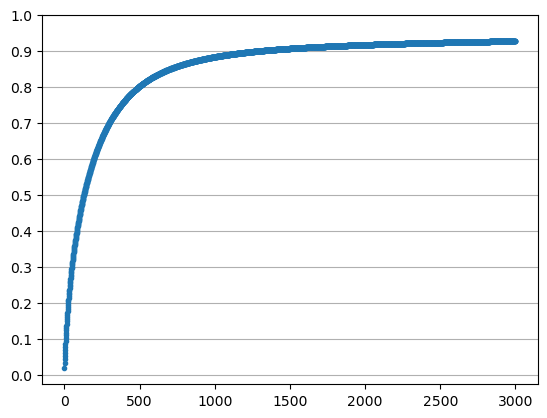

In [10]:
fig = plt.figure()
ax = plt.gca()
vnum = 3000
data = [sum(df_sorted['Skaits'][:i+1])/total for i in range(vnum)]
ax.plot(range(vnum),data,marker='.')
# ax.axhline(total)
ax.set_yticks([i/10 for i in range(11)])
ax.grid(axis='y')
plt.show()

### Vārdu daudzums katrā kategorijā

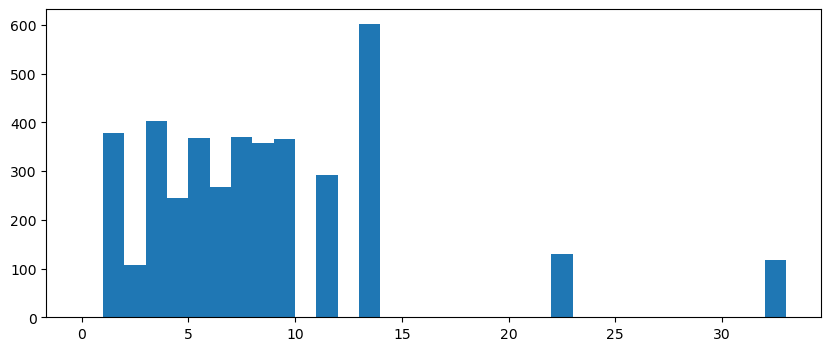

In [56]:
fig = plt.figure(figsize=(10,4))
ax = plt.gca()
vnum = 4000
data = [vards_to_num(v) for v in df_sorted['Vardi'][:vnum]]
ax.hist(data,bins=range(34))
plt.show()

### Vizualizācija ar vārdiem

In [ ]:
def render(vnum, verbose=True):
    fig = plt.figure(figsize=(14,7))
    ax = plt.gca()
    ax.set_xlim([.4,13.6])
    ax.set_ylim([-.5,17.5])
    
    count_sofar = {i:0 for i in range(13)}
    x_last = vards_to_num(df_sorted.iloc[vnum-1]['Vardi'])
    if x_last > 9:
        x_last = {11:10, 22:11, 33:12, 13:13}[x_last]
    
    sum_sofar = 0
    for row_index in range(vnum):
        current_row = df_sorted.iloc[row_index]
        v,n = (current_row['Vardi'],current_row['Skaits'])
        x = vards_to_num(v)
        
        if x==11:
            x=10
        elif x==22:
            x=11
        elif x==33:
            x=12
    
        if row_index == vnum-1:
            text_draw_mpl(fig, ax, v, x-.4, count_sofar[x-1], .8, 1, color='#d62728', bg='#F7D4D4', remove_gaps = False)
        elif x == x_last:
            text_draw_mpl(fig, ax, v, x-.4, count_sofar[x-1], .8, 1, color='#1f77b4', bg='#F7D4D4', remove_gaps = False)        
        else:
            text_draw_mpl(fig, ax, v, x-.4, count_sofar[x-1], .8, 1, color='#1f77b4', bg='white', remove_gaps = False)
        count_sofar[x-1] += 1 
        sum_sofar += n
        
    # Inset pie chart
    axins = ax.inset_axes([0.8, 0.7, 0.2, 0.3])
    axins.pie([sum_sofar-n,n,total-sum_sofar],colors=['C0','C3',(.9,.9,.9)])
    ax.text(.9,.65,v,transform=ax.transAxes,ha='center',va='center',c='C3',fontweight='bold',fontsize=14)
    ax.text(.9,.6,str(n),transform=ax.transAxes,ha='center',va='center',c='C3',fontweight='bold',fontsize=14)
    
    # Style
    ax.set_xticks(range(1,14))
    ax.set_xticklabels([
        '1\nLīdere','2\nMaigs','3\nJautrs un\ndaudzpusīgs','4\nPanākumi\nzinātnē','5\nBrīvība un\nneatkarība',
        '6\nCiti uzticas','7\nZinātniece,\nmāksliniece','8\nVeiksme, vara,\nbagātība','9\nZiedojas\nmērķim',
        '11\nAtklāsmes,\nmoceklis','22\nMeistare,\nvisu apvieno','33\nAltruisms un\nhumānisms','nav'
    ])
    if max(count_sofar.values())>16:
        ax.set_ylim([-.5,max(count_sofar.values())+.5])
    ax.spines[['top','right']].set_visible(False)
    ax.get_xticklabels()[x-1].set_color('C3')
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    rect = Rectangle((x-.5,-.2), 1, count_sofar[x-1]+.4,color='C3',alpha=.2,zorder=-2,ec=None)
    ax.add_patch(rect)
    
    # Save and show
    plt.tight_layout()
    plt.savefig('images/'+str(vnum)+'.png',dpi=72)
    if verbose:
        plt.show()
    plt.clf()
    plt.close()


/tmp/ipykernel_628289/298241394.py:11: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = pil_font.getsize(text)
/tmp/ipykernel_628289/298241394.py:13: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = pil_font.getsize(text)


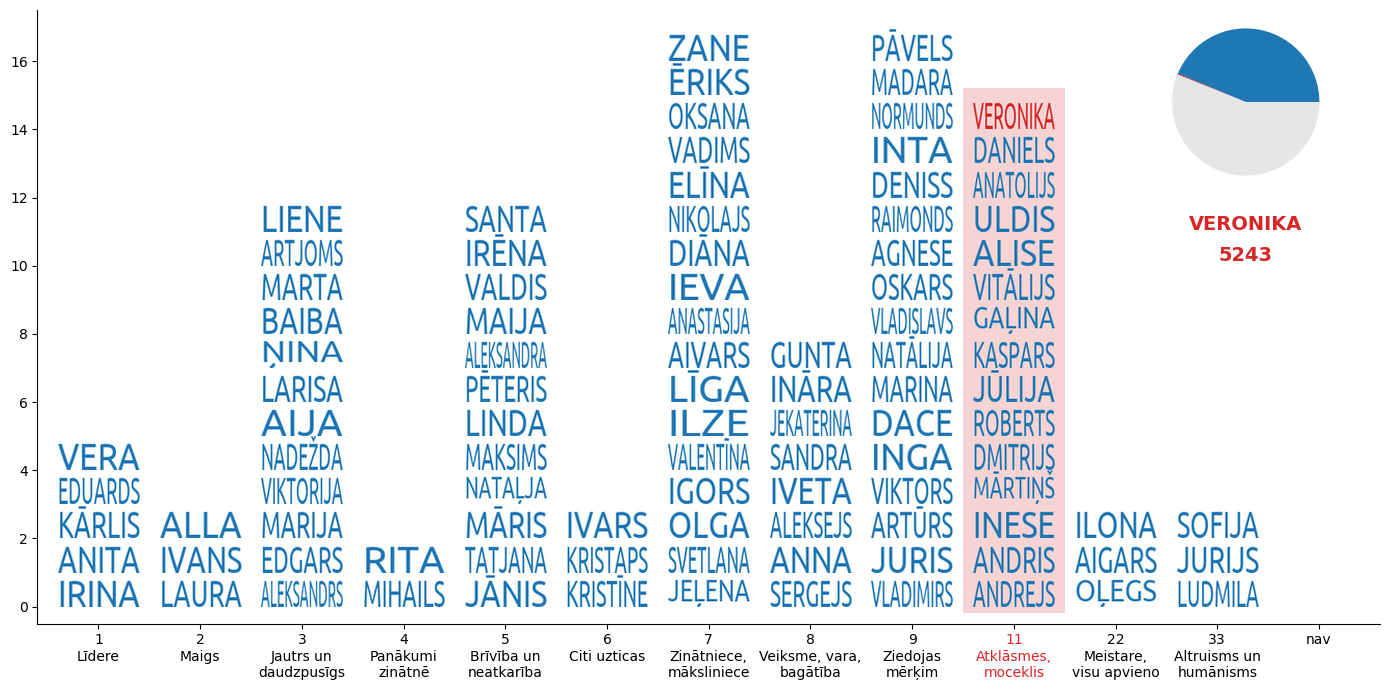

In [53]:
render(100)

In [36]:
for i in range(1,400):
    print(i, end=' ', flush=True)
    render(i,verbose=False)

1 

/tmp/ipykernel_628289/298241394.py:11: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = pil_font.getsize(text)
/tmp/ipykernel_628289/298241394.py:13: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = pil_font.getsize(text)


2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 27

### Saliec kopā gif

In [41]:
import imageio
images = []
for filename in ['images/'+str(i)+'.png' for i in range(1,400)]:
    images.append(imageio.imread(filename)) 
imageio.mimsave('vardi.gif',images,duration=0.05)

/tmp/ipykernel_628289/1920016898.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


### Cilvēku skaits katrā kategorijā

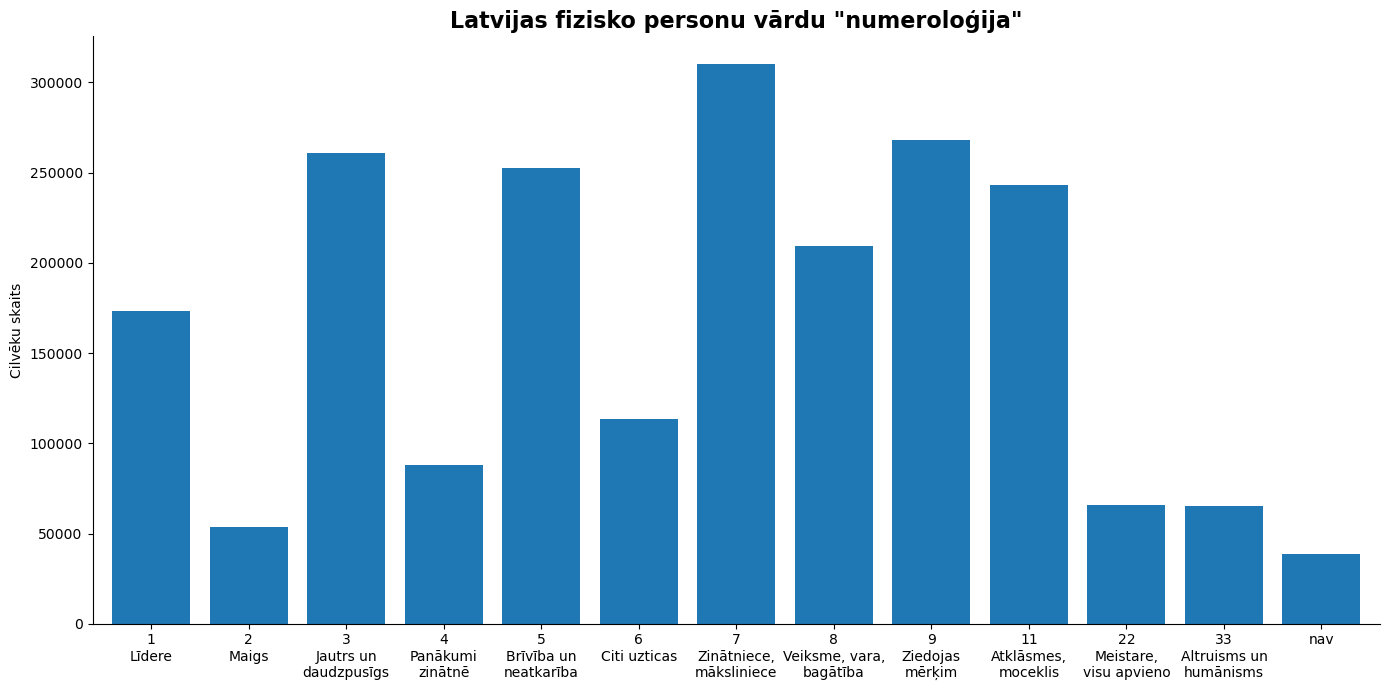

In [55]:
fig = plt.figure(figsize=(14,7))
ax = plt.gca()
vnum = 5000
data = [0]*13
for row_index in range(vnum):
    current_row = df_sorted.iloc[row_index]
    v,n = (current_row['Vardi'],current_row['Skaits'])
    x = vards_to_num(v)
    
    if x==11:
        x=10
    elif x==22:
        x=11
    elif x==33:
        x=12
    
    data[x-1] += n

# Draw
ax.bar(list(range(1,14)),data)

# Style
ax.set_title('Latvijas fizisko personu vārdu \"numeroloģija\"',fontweight='bold',fontsize=16)
ax.set_xlim([.4,13.6])
ax.set_xticks(range(1,14))
ax.set_xticklabels([
    '1\nLīdere','2\nMaigs','3\nJautrs un\ndaudzpusīgs','4\nPanākumi\nzinātnē','5\nBrīvība un\nneatkarība',
    '6\nCiti uzticas','7\nZinātniece,\nmāksliniece','8\nVeiksme, vara,\nbagātība','9\nZiedojas\nmērķim',
    '11\nAtklāsmes,\nmoceklis','22\nMeistare,\nvisu apvieno','33\nAltruisms un\nhumānisms','nav'
])
ax.spines[['top','right']].set_visible(False)
ax.set_ylabel('Cilvēku skaits')

# Show
plt.tight_layout()
plt.savefig('tw3a.png',dpi=300)
plt.show()

### Ministru prezidenti

/tmp/ipykernel_628289/298241394.py:11: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = pil_font.getsize(text)
/tmp/ipykernel_628289/298241394.py:13: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = pil_font.getsize(text)


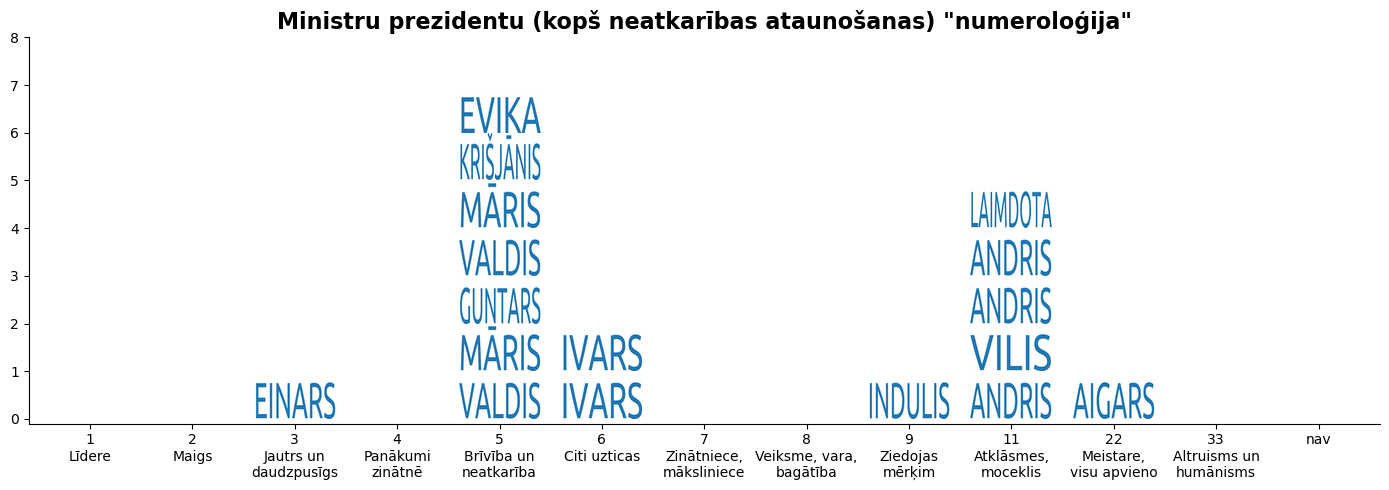

In [54]:
fig = plt.figure(figsize=(14,5))
ax = plt.gca()
ax.set_ylim([-.1,8])

# name_list = ['JĀNIS','GUSTAVS','ALBERTS','KĀRLIS','GUNTIS','VAIRA','VALDIS','ANDRIS','RAIMONDS','EGILS','EDGARS']
name_list = ['IVARS','VALDIS','MĀRIS','ANDRIS','GUNTARS','VILIS','ANDRIS','ANDRIS','EINARS','INDULIS','AIGARS','IVARS','VALDIS','LAIMDOTA','MĀRIS','KRIŠJĀNIS','EVIKA']
    
count_sofar = {i:0 for i in range(13)}
for name in name_list:
    x = vards_to_num(name)
    
    if x==11:
        x=10
    elif x==22:
        x=11
    elif x==33:
        x=12

    text_draw_mpl(fig, ax, name, x-.4, count_sofar[x-1], .8, 1, color='#1f77b4', bg='white', remove_gaps = False)
    # text_draw_mpl(fig, ax, v, x-.4, sum_sofar[x-1], .8, n, color=(1,1,1), bg='C0', remove_gaps = True)
    count_sofar[x-1] += 1 
    
# ax.bar(list(range(1,13)), data, width=.9, zorder=-2)

# Style
ax.set_title('Ministru prezidentu (kopš neatkarības ataunošanas) \"numeroloģija\"',fontweight='bold',fontsize=16)
ax.set_xlim([.4,13.6])
ax.set_xticks(range(1,14))
ax.set_xticklabels([
    '1\nLīdere','2\nMaigs','3\nJautrs un\ndaudzpusīgs','4\nPanākumi\nzinātnē','5\nBrīvība un\nneatkarība',
    '6\nCiti uzticas','7\nZinātniece,\nmāksliniece','8\nVeiksme, vara,\nbagātība','9\nZiedojas\nmērķim',
    '11\nAtklāsmes,\nmoceklis','22\nMeistare,\nvisu apvieno','33\nAltruisms un\nhumānisms','nav'
])
ax.spines[['top','right']].set_visible(False)

# Show
plt.tight_layout()
plt.savefig('tw4a.png',dpi=150)
plt.show()

### Mēginājums stiept vārdus vertikāli

/tmp/ipykernel_628289/298241394.py:11: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = pil_font.getsize(text)
/tmp/ipykernel_628289/298241394.py:13: DeprecationWarning: getsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use getbbox or getlength instead.
  text_width, text_height = pil_font.getsize(text)


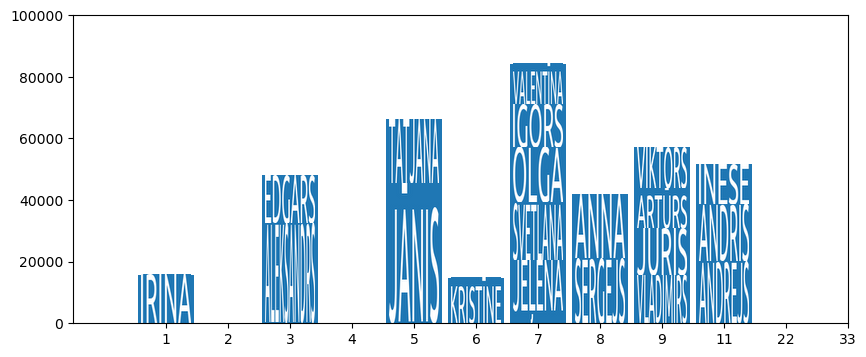

In [62]:
fig = plt.figure(figsize=(10,4))
ax = plt.gca()
ax.set_xlim([-.5,11.5])
ax.set_ylim([0,100000])

vnum = 20
data = [0]*12
sum_sofar = {i:0 for i in range(12)}
for row_index in range(vnum):
    current_row = df_sorted.iloc[row_index]
    v,n = (current_row['Vardi'],current_row['Skaits'])
    x = vards_to_num(v)
    
    if x==11:
        x=10
    elif x==22:
        x=11
    elif x==33:
        x=12
    data[x-1] += n
    # ax.text(x-.4,sum_sofar[x-1],v,ha='left',va='bottom')
    text_draw_mpl(fig, ax, v, x-.4, sum_sofar[x-1]+10, .8, n-20, color='white', bg='#1f77b4', remove_gaps = True)
    # text_draw_mpl(fig, ax, v, x-.4, sum_sofar[x-1], .8, n, color=(1,1,1), bg='C0', remove_gaps = True)
    sum_sofar[x-1] += n 
    
ax.bar(list(range(1,13)), data, width=.9, zorder=-2)

# Style
ax.set_xticks(range(1,13))
ax.set_xticklabels(['1','2','3','4','5','6','7','8','9','11','22','33'])

# Show
plt.show()